In [18]:
import numpy as np
import torch

In [19]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

## Equação de Burgers

A equação de Burgers é dada através da seguinte equação diferencial:

$$
\dfrac{\partial u}{\partial t} + u\dfrac{\partial u}{\partial x} = \alpha \dfrac{\partial^2 u}{\partial x^2}, \hspace{1cm}  x\in [-1,1],t\in [0,1]
$$

onde $\alpha = \dfrac{0.01}{\pi}$, $u(-1,t) = u(1,t) = 0$ e $u(x,0) = -\sin(\pi x)$.

In [20]:
#PARAMETROS DA EQUAÇÃO
alpha = 0.01/torch.pi

#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def pde(x, t, model):
    input = torch.stack((x,t),1)

    u = model(input)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    return u_t + u * u_x - alpha * u_xx

#DECLARAÇÃO DO DOMÍNIO
x_dom = (-1,1)
t_dom = (0,1)
batch_size = 1000

#DECLARAÇÃO DAS CONDIÇÕES DE CONTORNO E PONTOS INTERNOS
x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_()
t = torch.FloatTensor(batch_size).uniform_(t_dom[0], t_dom[1]).requires_grad_()
ic_x = torch.tensor([-1.0,1.0])
ic_t = torch.tensor([0.0])

#PREPARAÇÃO DOS DADOS DE TREINAMENTO
input_ic1 = torch.cartesian_prod(ic_x, t)
input_ic2 = torch.cartesian_prod(x, ic_t)
ic_t_target = torch.sin(torch.pi * x)

#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(2, 1, 20, 1, torch.nn.Tanh()) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
learning_rate = 1e-3
epochs = 10000
optmizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
loss_fn = torch.nn.MSELoss()

In [21]:
#TREINAMENTO
for ep in range(epochs):

    optmizer.zero_grad()

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_icx = model(input_ic1)
    ic_x_target = torch.zeros_like(out_icx)
    l1 = loss_fn(out_icx, ic_x_target)

    out_ict = model(input_ic2)
    l2 = loss_fn(out_ict, ic_t_target)
    
    #CALCULO DO CUSTO PARA A EDP
    out_pde = pde(x, t, model)
    pde_target = torch.zeros_like(out_pde)
    l3 = loss_fn(out_pde, pde_target)
    
    #BACKPROPAGATION
    loss = l1 + l2 + l3
    loss.backward(retain_graph=True)
    optmizer.step()

    with torch.autograd.no_grad():
        print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')

Epochs: 0/10000 Loss: 1.0635982751846313
Epochs: 1/10000 Loss: 1.0192599296569824
Epochs: 2/10000 Loss: 0.9774693250656128
Epochs: 3/10000 Loss: 0.9381064772605896
Epochs: 4/10000 Loss: 0.9010438323020935
Epochs: 5/10000 Loss: 0.8661763072013855
Epochs: 6/10000 Loss: 0.8334024548530579
Epochs: 7/10000 Loss: 0.8026177287101746
Epochs: 8/10000 Loss: 0.7737162113189697
Epochs: 9/10000 Loss: 0.7465938329696655
Epochs: 10/10000 Loss: 0.7211509943008423
Epochs: 11/10000 Loss: 0.6972938179969788
Epochs: 12/10000 Loss: 0.6749356985092163
Epochs: 13/10000 Loss: 0.6539959907531738
Epochs: 14/10000 Loss: 0.6344003081321716
Epochs: 15/10000 Loss: 0.6160804033279419
Epochs: 16/10000 Loss: 0.5989727973937988
Epochs: 17/10000 Loss: 0.5830183029174805
Epochs: 18/10000 Loss: 0.5681617856025696
Epochs: 19/10000 Loss: 0.5543509125709534
Epochs: 20/10000 Loss: 0.5415361523628235
Epochs: 21/10000 Loss: 0.529670000076294
Epochs: 22/10000 Loss: 0.5187063813209534
Epochs: 23/10000 Loss: 0.5086007118225098
Epo

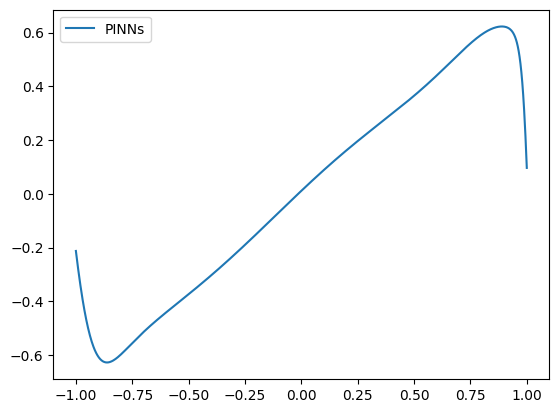

In [27]:
import matplotlib.pyplot as plt 

size = 1000
x_test = torch.linspace(x_dom[0], x_dom[1], size)
t_test = torch.tensor([1.0])
input = torch.cartesian_prod(x_test, t_test)
out = model(input)

x_test = x_test.detach().numpy()
out = out.detach().numpy()

#PLOTAGEM
plt.plot(x_test, out, label = 'PINNs')
plt.legend()
plt.show()